In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from torch.autograd import Variable
from sklearn import preprocessing
plt.rc('font', size=12)
random.seed(0)

In [2]:
# read in the data file
dat = pd.read_csv('dataset/auto-mpg.csv', na_values = '?',)
dat = dat.drop(columns = ['car name'])
y = dat['mpg']
x = dat.drop(columns = ['mpg'])
origin = x.pop('origin')
x['USA'] = (origin == 1) * 1.0
x['Europe'] = (origin == 2) * 1.0
x['Japan'] = (origin == 3) * 1.0
x = x.dropna()
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

ind = np.arange(x.shape[0])
random.shuffle(ind)
x = x[ind, :]
y = y[ind]

y_tensor = torch.tensor(y.values).float()
x_tensor = torch.tensor(x).float()

In [3]:
# create train / test split
n = len(y)
y_train = y_tensor[:300]
y_test = y_tensor[300:]
x_train = x_tensor[:300]
x_test = x_tensor[300:]

In [4]:
class ConcreteDropout(nn.Module):
    def __init__(self, weight_regularizer=1e-6,
                 dropout_regularizer=1e-5, init_min=0.1, init_max=0.1):
        super(ConcreteDropout, self).__init__()

        
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        
        self.p_logit = nn.Parameter(torch.empty(1).uniform_(init_min, init_max))
        
    def forward(self, x, layer):
        p = torch.sigmoid(self.p_logit)
        
        out = layer(self._concrete_dropout(x, p))
        
        sum_of_square = 0
        for param in layer.parameters():
            sum_of_square += torch.sum(torch.pow(param, 2))
        
        weights_regularizer = self.weight_regularizer * sum_of_square / (1 - p)
        
        dropout_regularizer = p * torch.log(p)
        dropout_regularizer += (1. - p) * torch.log(1. - p)
        
        input_dimensionality = x[0].numel() # Number of elements of first item in batch
        dropout_regularizer *= self.dropout_regularizer * input_dimensionality
        
        regularization = weights_regularizer + dropout_regularizer
        return out, regularization
        
    def _concrete_dropout(self, x, p):
        eps = 1e-7
        temp = 0.1

        unif_noise = torch.rand_like(x)

        drop_prob = (torch.log(p + eps)
                    - torch.log(1 - p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        
        drop_prob = torch.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - p
        
        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        
        return x

In [5]:
class Model(nn.Module):
    def __init__(self, nb_features, weight_regularizer, dropout_regularizer):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(9, nb_features)
        self.linear2 = nn.Linear(nb_features, nb_features)
        self.linear3 = nn.Linear(nb_features, nb_features)

        self.linear4_mu = nn.Linear(nb_features, 1)
        self.linear4_logvar = nn.Linear(nb_features, 1)

        self.conc_drop1 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop2 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop3 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop_mu = ConcreteDropout(weight_regularizer=weight_regularizer,
                                             dropout_regularizer=dropout_regularizer)
        self.conc_drop_logvar = ConcreteDropout(weight_regularizer=weight_regularizer,
                                                 dropout_regularizer=dropout_regularizer)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        regularization = torch.empty(5, device=x.device)
        
        x1, regularization[0] = self.conc_drop1(x, nn.Sequential(self.linear1, self.relu))
        x2, regularization[1] = self.conc_drop2(x1, nn.Sequential(self.linear2, self.relu))
        x3, regularization[2] = self.conc_drop3(x2, nn.Sequential(self.linear3, self.relu))

        mean, regularization[3] = self.conc_drop_mu(x3, self.linear4_mu)
        log_var, regularization[4] = self.conc_drop_logvar(x3, self.linear4_logvar)

        return mean, log_var, regularization.sum()

def heteroscedastic_loss(true, mean, log_var):
    precision = torch.exp(-log_var)
    return torch.mean(torch.sum(precision * (true - mean)**2 + log_var, 1), 0)

In [6]:
nb_epochs = [2000, 1000, 500, 200, 20, 2]
nb_features = 20 # Hidden layer size
Q = 9 # Data dimensionality
D = 1 # One mean, one log_var
K_test = 20 # Number of MC samples
nb_reps = 3 # Number of times to repeat experiment
batch_size = 50
l = 1e-4 # Lengthscale

In [7]:
def fit_model(nb_epoch, X, Y):
    N = X.shape[0]
    wr = l**2. / N
    dr = 2. / N
    model = Model(nb_features, wr, dr)
    model = model
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    
    for i in range(nb_epoch):
        old_batch = 0
        for batch in range(int(np.ceil(X.shape[0]/batch_size))):
            batch = (batch + 1)
            _x = X[old_batch: batch_size*batch]
            _y = Y[old_batch: batch_size*batch]
            
            x = Variable(torch.FloatTensor(_x))
            y = Variable(torch.FloatTensor(_y))
            
            mean, log_var, regularization = model(x)
                        
            loss = heteroscedastic_loss(y, mean, log_var) + regularization
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            old_batch = batch_size*batch
        
    print('final loss: ', loss.item())
        
    return model

In [8]:
model = fit_model(1000, x_train, y_train.reshape(-1, 1))

final loss:  4.4337077140808105


In [9]:
print('MAPE on test data using NLLK loss: ', torch.mean(torch.abs((model(x_test)[0].squeeze(1) - y_test) / y_test)))
print('MAPE on training data using NLLK loss: ', torch.mean(torch.abs((model(x_train)[0].squeeze(1) - y_train) / y_train)))

MAPE on test data using NLLK loss:  tensor(0.2110, grad_fn=<MeanBackward0>)
MAPE on training data using NLLK loss:  tensor(0.2015, grad_fn=<MeanBackward0>)


In [10]:
n_test = 92
mean_test, log_var_test, _ = model(x_test)
var_test = torch.exp(log_var_test)

pcdf = torch.empty(n_test)

for i in range(n_test):
    m = torch.distributions.normal.Normal(mean_test[i], torch.sqrt(var_test[i]), validate_args=None)
    pcdf[i] = m.cdf(y_test[i])

print(pcdf)

tensor([0.1588, 0.2007, 0.5425, 0.9423, 0.9114, 0.1209, 0.9066, 0.6048, 0.4680,
        0.2746, 0.4451, 0.2090, 0.5154, 0.6410, 0.5190, 0.1702, 0.1945, 0.8412,
        0.4572, 0.7291, 0.3052, 0.4570, 0.6848, 0.3005, 0.2519, 0.2397, 0.4592,
        0.8194, 0.4039, 0.9893, 0.2395, 0.5111, 0.2688, 0.0611, 0.4574, 0.8118,
        0.0560, 0.0168, 0.3304, 0.2207, 0.5565, 0.6436, 0.7202, 0.2817, 0.8167,
        0.5561, 0.6549, 0.3741, 0.5072, 0.1134, 0.5870, 0.3493, 0.7918, 0.4377,
        0.2837, 0.7538, 0.9855, 0.1601, 0.2508, 0.9344, 0.8987, 0.3143, 0.2355,
        0.2847, 0.6559, 0.8774, 0.6067, 0.3284, 0.0349, 0.3948, 0.4376, 0.3183,
        0.0150, 0.1178, 0.1126, 0.6430, 0.8788, 0.9167, 0.3010, 0.1798, 0.3614,
        0.5631, 0.9941, 0.2628, 0.2162, 0.9923, 0.1822, 0.9118, 0.7938, 0.0082,
        0.0958, 0.9389], grad_fn=<CopySlices>)


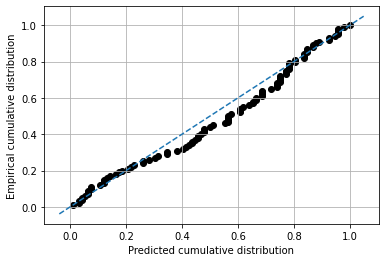

In [11]:
p = np.arange(0,1,0.01) + 0.01
pcdf = pcdf.detach().numpy()
cumulative_pcdf = np.zeros(len(p))
for i in range(len(p)):
    cumulative_pcdf[i] = np.mean(pcdf <= p[i])

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

fig, ax = plt.subplots()
ax.scatter(cumulative_pcdf, p, c='black')
abline(1, 0)
plt.grid()
plt.xlabel('Predicted cumulative distribution')
plt.ylabel('Empirical cumulative distribution')
plt.show()

In [12]:
# compute calibration error given a step size
step = .001
p = np.arange(0,1,step) + step
cumulative_pcdf = np.zeros(len(p))
for i in range(len(p)):
    cumulative_pcdf[i] = np.mean(pcdf <= p[i])
print(np.sum((cumulative_pcdf - p) ** 2))

step = .01
p = np.arange(0,1,step) + step
cumulative_pcdf = np.zeros(len(p))
for i in range(len(p)):
    cumulative_pcdf[i] = np.mean(pcdf <= p[i])
print(np.sum((cumulative_pcdf - p) ** 2))

step = .1
p = np.arange(0,1,step) + step
cumulative_pcdf = np.zeros(len(p))
for i in range(len(p)):
    cumulative_pcdf[i] = np.mean(pcdf <= p[i])
print(np.sum((cumulative_pcdf - p) ** 2))

2.3180349716446114
0.23343572778827962
0.018761814744801493
